# Solar Flare Prediction with LSTM Network

<h2>This project aims to predict solar flare activity by analyzing solar X-ray flux data collected by NOAA's GOES satellites. Solar flares can disrupt communication systems, satellites, and power grids on Earth, making accurate prediction essential for mitigating potential damage.</h2>

<img width=500 src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6a/X3.2_Solar_flare_on_2013-05-14_at_four_wavelengths.jpg/800px-X3.2_Solar_flare_on_2013-05-14_at_four_wavelengths.jpg?20130514163232"></img>

<h2>Using a Long Short-Term Memory (LSTM) neural network, this model processes recent flux measurements to forecast future solar activity.</h2>

<h3>* Required Imports :</h3>

In [2]:
import requests
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

<h3>* Downloading the Data : </h3>

* For this project I'm going to use data of past 7 days.

* With the data from past seven days our model should have better at making short-term flux predictions.

In [3]:
# Step 1: Helper function for Downloading Solar X-Ray Flux Data
def download_data():
    url = "https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        df = pd.DataFrame(data)

        return df

    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return pd.DataFrame()

<h4>This function downloads solar X-ray flux data from NOAA's API:</h4>

* It requests JSON data from the URL and handles any potential errors in the request.
* The JSON response is converted into a pandas DataFrame for further processing.

In [ ]:
# Step 2: Loading the Data
df = download_data()

df.head()

,time_tag,satellite,flux,observed_flux,electron_correction,electron_contaminaton,energy
0,2024-10-28T06:03:00Z,16,5.739343e-08,7.503226e-08,1.763883e-08,False,0.05-0.4nm
1,2024-10-28T06:03:00Z,16,2.841022e-06,2.894122e-06,5.310042e-08,False,0.1-0.8nm
2,2024-10-28T06:04:00Z,16,5.306582e-08,7.060792e-08,1.754210e-08,False,0.05-0.4nm
3,2024-10-28T06:04:00Z,16,2.817517e-06,2.872469e-06,5.495217e-08,False,0.1-0.8nm
4,2024-10-28T06:05:00Z,16,5.249366e-08,6.924297e-08,1.674931e-08,False,0.05-0.4nm


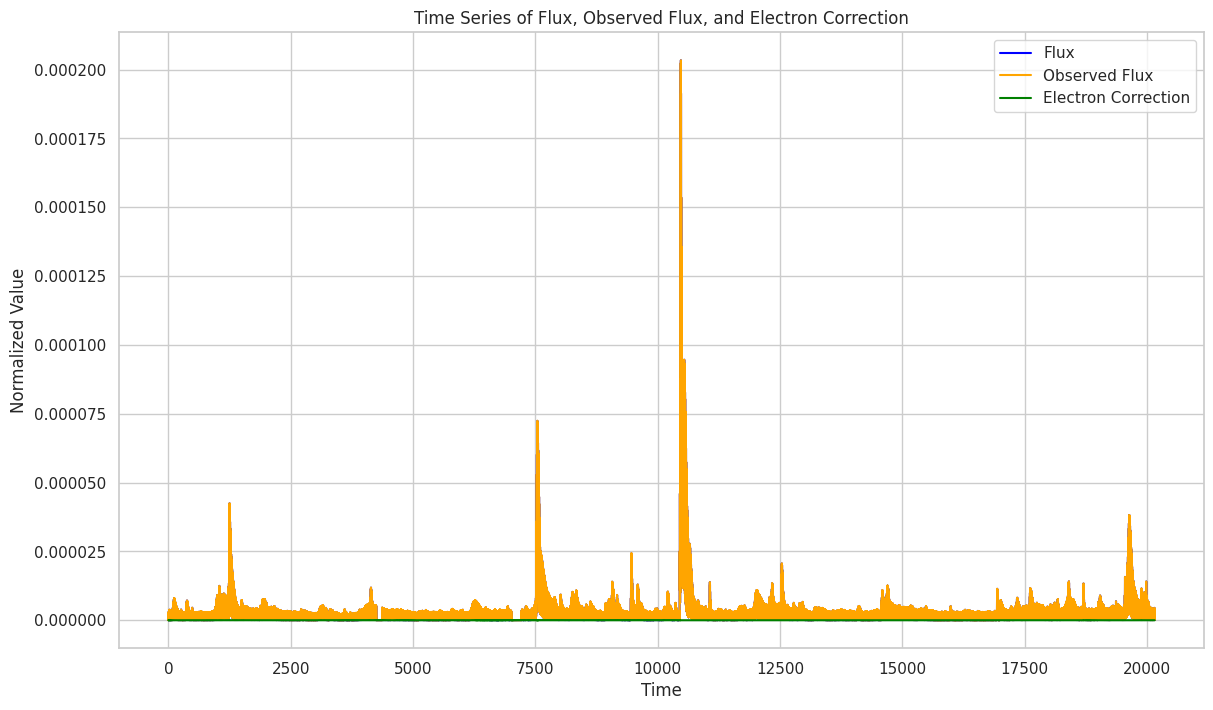

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

# Set up plotting style for clearer visuals
sns.set(style="whitegrid")

# Step 1: Plotting the time series data
# This gives a quick overview of the general trend in each of the columns over time.
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['flux'], label="Flux", color="blue")
plt.plot(df.index, df['observed_flux'], label="Observed Flux", color="orange")
plt.plot(df.index, df['electron_correction'], label="Electron Correction", color="green")
plt.title("Time Series of Flux, Observed Flux, and Electron Correction")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()

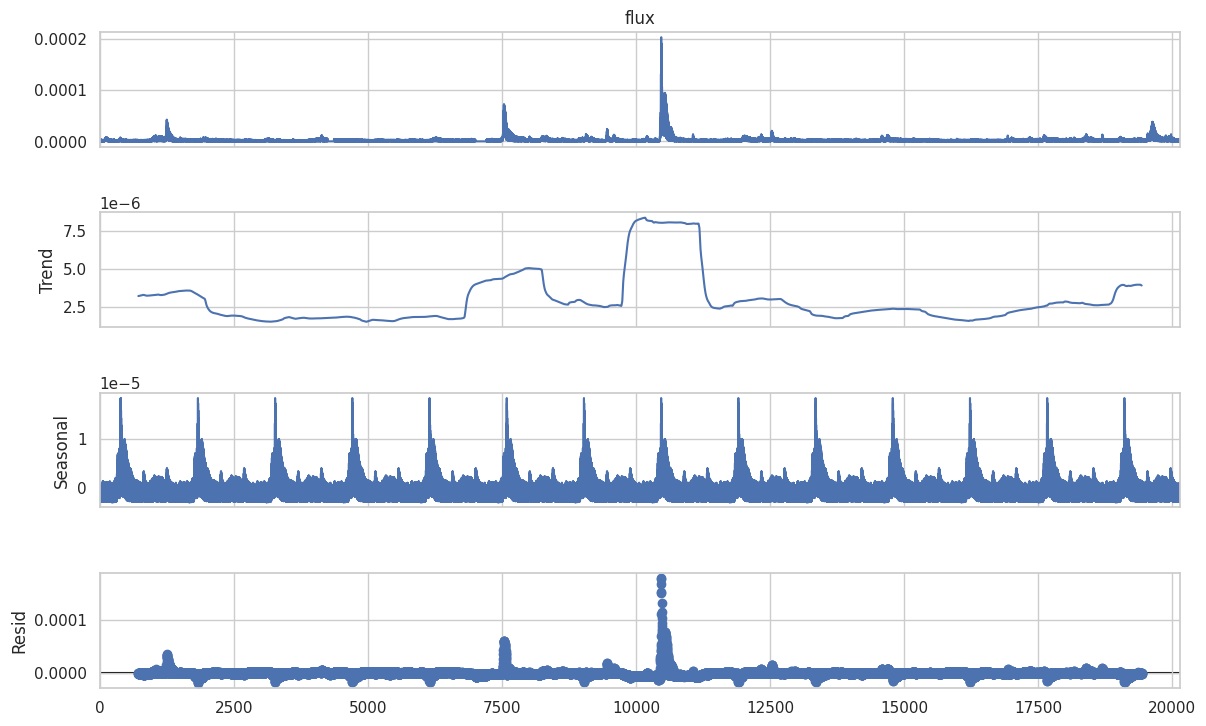

In [ ]:
# Step 2: Decompose the 'flux' series to analyze trend, seasonality, and residuals
# Using seasonal decomposition to break down the time series data into trend, seasonality, and residual components.
decomposition = sm.tsa.seasonal_decompose(df['flux'], model='additive', period=1440)  # Assuming daily periodicity

fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

<h4>This decomposition plot for `flux` have following observations:

1. **Original Series**: Shows the raw `flux` values, with noticeable spikes indicating intense solar events.

2. **Trend**: Illustrates a slowly varying pattern over time, with a subtle increase and decrease, capturing long-term shifts in flux levels.

3. **Seasonal**: Highlights regular, repeating patterns in the data. We can observe that solar activity has periodic fluctuations.

4. **Residual**: Contains noise or irregular variations not explained by trend or seasonality, with some higher residuals during intense solar events.

This breakdown helps isolate the different components, aiding in better understanding and prediction of solar flux behavior.</h4>

In [ ]:
# Step 3: Stationarity Test (Augmented Dickey-Fuller Test)
# Testing for stationarity of the 'flux' series. Stationarity is important for many time series models.
result = adfuller(df['flux'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -8.776315703581494
p-value: 2.4434419923173615e-14
Critical Value (1%): -3.4306752503972833
Critical Value (5%): -2.86168374928695
Critical Value (10%): -2.5668465138102072


<h4>The Augmented Dickey-Fuller (ADF) test checks if the time series is stationary (i.e. its statistical properties, such as mean and variance, do not change over time). A low p-value typically < 0.05 suggests that the series is stationary.</h4>

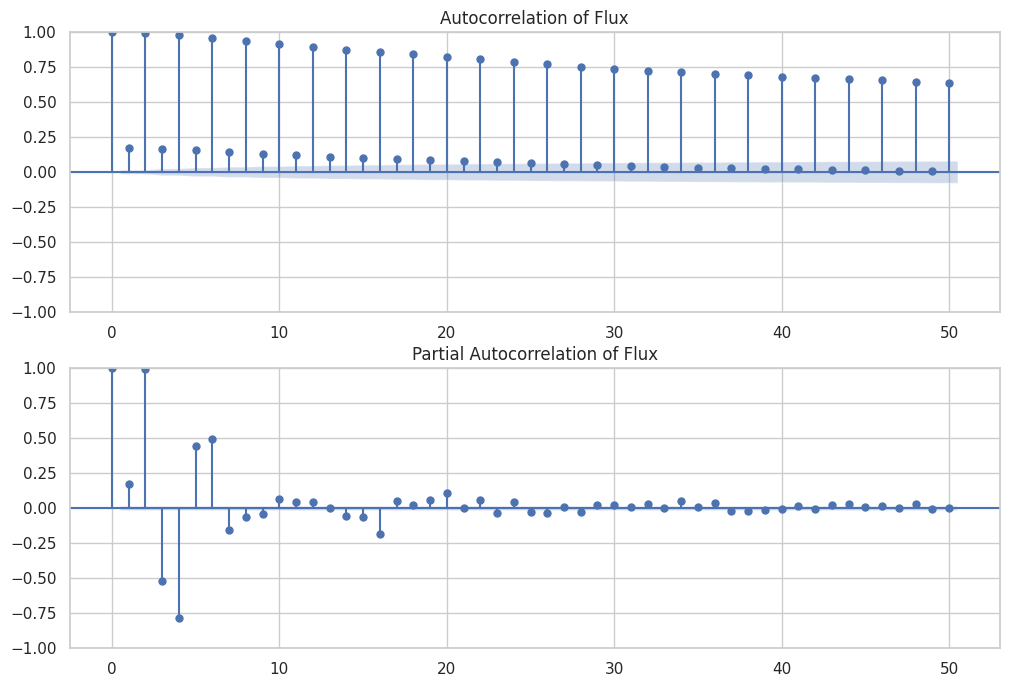

In [ ]:
# Step 4: Autocorrelation and Partial Autocorrelation
# These plots help identify dependencies in the time series data.
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plotting autocorrelation and partial autocorrelation for the 'flux' data
sm.graphics.tsa.plot_acf(df['flux'], lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['flux'], lags=50, ax=ax[1])

ax[0].set_title("Autocorrelation of Flux")
ax[1].set_title("Partial Autocorrelation of Flux")
plt.show()

<h4>These autocorrelation and partial autocorrelation plots for `flux` have following obseravtions:

1. **Autocorrelation Function (ACF)**: There is a strong correlation at multiple lags, with gradual decay, indicating that `flux` values are highly correlated with previous values. This suggests non-randomness and possible seasonality in the data.

2. **Partial Autocorrelation Function (PACF)**: The initial lags have strong correlations, especially at the first few lags, but it drops off quickly. This pattern suggests that the flux time series could be modeled using a few recent past values.

These patterns confirm the time series is non-stationary and contains both short and long-term dependencies.</h4>

<h3>* Data Preprocessing : </h3>

In [ ]:
# Step 3: Preprocessing the data
# Converting time_tag to datetime and set as index
df['time_tag'] = pd.to_datetime(df['time_tag'])
df.set_index('time_tag', inplace=True)

# Selecting relevant columns
df = df[['flux', 'observed_flux', 'electron_correction', 'energy']]

# Filtering for specific energy range(e.g. : "0.1-0.8nm")
df = df[df['energy'] == "0.1-0.8nm"]
df.drop(columns=['energy'], inplace=True)

# Filling missing values
df.fillna(method='ffill', inplace=True)

# Scaling data
scaler = MinMaxScaler()
df[['flux', 'observed_flux', 'electron_correction']] = scaler.fit_transform(df[['flux', 'observed_flux', 'electron_correction']])

print("Preprocessed data:")
print(df.head())

Preprocessed data:
                               flux  observed_flux  electron_correction
time_tag                                                               
2024-10-28 05:54:00+00:00  0.012510       0.012815             0.888443
2024-10-28 05:55:00+00:00  0.012554       0.012856             0.878229
2024-10-28 05:56:00+00:00  0.012678       0.012985             0.894617
2024-10-28 05:57:00+00:00  0.012888       0.013179             0.847633
2024-10-28 05:58:00+00:00  0.013229       0.013501             0.790771


<ipython-input-4-7d4311895275>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


<h4>Above block performs essential data preprocessing:</h4>

* Converts the time_tag column to a datetime format and sets it as the index for time-series analysis.

* Filters the data for a specific energy range ("0.1-0.8nm"), a relevant range for solar flare analysis.

* Fills any missing values to ensure data continuity.

* Scales the flux, observed_flux, and electron_correction columns to a range of 0-1 using MinMaxScaler for better performance in training the LSTM model.

<h3>* But what does the features that we are using actually mean? </h3>

<h3>let's take a look!</h3>

<b>1. Flux</b>

* <strong>Definition:</strong> Flux is the amount of solar X-ray energy that passes through a given area in a specific time. It’s essentially a measurement of the intensity of solar X-rays hitting the Earth.

* <strong>Unit:</strong> Usually measured in watts per square meter (W/m²).

<b>2. Observed Flux</b>

* <strong>Definition:</strong> Observed flux is the actual X-ray flux measurement recorded by the satellite or ground-based sensors. It represents the real-world reading, which includes not only the solar X-rays but also any additional influences that affect the sensor’s reading.

<b>3. Electron Correction</b>

* <strong>Definition:</strong> Electron correction is an adjustment factor applied to the observed flux to correct for interference caused by high-energy electrons hitting the sensor.

* <strong>Example:</strong> Imagine a satellite is passing through a region of space with a lot of high-energy electrons. These electrons can affect the sensor’s reading, so an electron correction factor might be applied to filter out this "noise" and give a more accurate measure of the X-ray flux. If the observed flux is 1.8 x 10⁻⁵ W/m², the electron correction might adjust it to 1.5 x 10⁻⁵ W/m² to account for interference.

<b>4. Energy</b>

* <strong>Definition:</strong> In this dataset, energy refers to the wavelength range or energy band of the X-rays being measured, which can indicate the type and intensity of solar emissions.


<h3>* Data Preparation : </h3>

In [ ]:
# Preparing data for LSTM
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length][0])  # Target is the 'flux' value
    return np.array(X), np.array(y)

# Converting to numpy array and create sequences
data = df[['flux']].values
sequence_length = 60
X, y = create_sequences(data, sequence_length)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (10017, 60, 1)
Shape of y: (10017,)


<h4>Above block prepares the data for the LSTM model:</h4>

* Defines the helper function create_sequences, to generate sequences of 60 time steps (the sequence_length) as input for our model. The target value (y) is the flux at the next time step after each sequence.

* Then Converts the data to numpy arrays and generates X (features) and y (labels) to be used for training the model.

<h3>* Model Architecture : </h3>

In [ ]:
# Step 4: Defining the LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<h4>Above block defines the LSTM model architecture:</h4>

* It Uses an LSTM layer with 50 units and ReLU activation, followed by a Dense layer with a single unit for regression output.

* The model is compiled with the Adam optimizer and Mean Squared Error (MSE) loss function, which is a common choice for regression tasks.

<h3>* Training : </h3>

In [ ]:
# Step 5: Training the Model
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 2.0275e-04 - val_loss: 1.6831e-05
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 2.4070e-04 - val_loss: 1.6231e-05
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.4257e-04 - val_loss: 1.6303e-05
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 1.7815e-04 - val_loss: 1.7584e-05
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 7.0614e-05 - val_loss: 2.1915e-05
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 8.5817e-05 - val_loss: 1.7560e-05
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 3.5634e-05 - val_loss: 2.9299e-05
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 3.9685e-05 - val_loss: 1.3616e-05
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 7.0914e-05 - val_loss: 1.1666e-05
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 5.1141e-05 - val_loss: 9.1414e-06


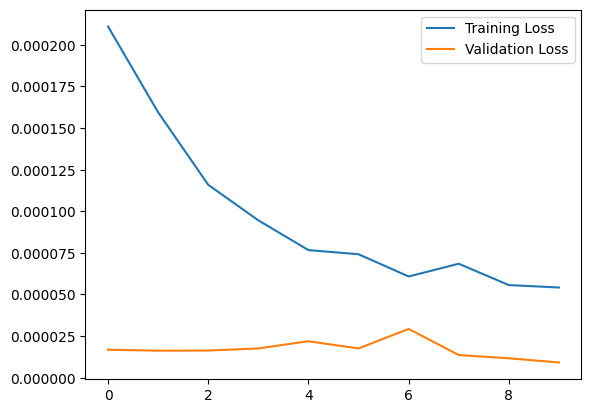

In [ ]:
# Ploting training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

<h4>Above block trains the LSTM model on our data:</h4>

* It Trains the model for 10 epochs with a batch size of 32, using 20% of data for validation.

* Then it Plots the training and validation loss.

<h3>* Evaluation : </h3>

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


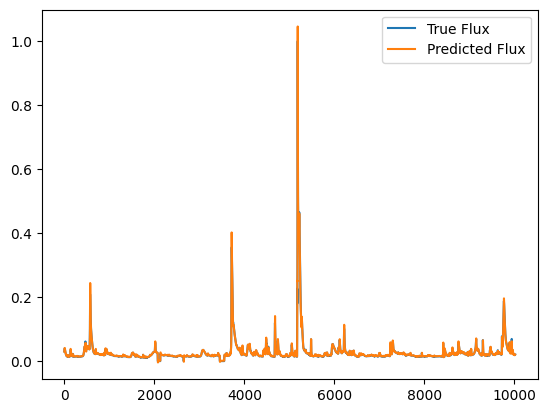

In [ ]:
# Step 6: Evaluating the Model
predictions = model.predict(X)
plt.plot(y, label="True Flux")
plt.plot(predictions, label="Predicted Flux")
plt.legend()
plt.show()


<h4>This final block evaluates the model by generating predictions on the training data:</h4>

* Plots the true flux values against the predicted flux values, allowing a visual assessment of how well the model captures the patterns in the data.